## Preparation

Import necessary packages and initalize common parameters

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_svmlight_file
import math


# paremeters
epoch = 2
batch_size = 128
eta = 0.2
lbda = 0.1
momentum = 0.9

Load training data set and validation data set

In [3]:
def get_data(data_path, n_features):
    X, y = load_svmlight_file(data_path, n_features=n_features)
    X = X.toarray()
    b = np.ones((X.shape[0], 1))
    X = np.concatenate((b, X), axis=1)
    y = np.expand_dims(y, axis=1)
    return X, y

X_train, y_train = get_data('./a9a.txt', n_features=123)
X_validation, y_validation = get_data('./a9a.t', n_features=123)
sample_num, dim = X_train.shape
validation_num = X_validation.shape[0]
batch_num = int(math.ceil((sample_num / batch_size)*1.0))

Initialize weights

In [4]:
W_SGD = np.random.randn(X_train.shape[1], 1)
W_NAG = np.copy(W_SGD)
W_RMSProp = np.copy(W_SGD)
W_AdaDelta = np.copy(W_SGD)
W_Adam = np.copy(W_SGD)

Functions to show loss and error

In [5]:
def show_loss(train_loss, test_loss):
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='train_loss', linewidth=2.0)
    ax.plot(test_loss, label='validation_loss', linewidth=2.0)
    ax.set(xlabel='Iteration', ylabel='Loss')
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.show()
    
def show_accuracy(val_accuracy):
    fig, ax = plt.subplots()
    ax.plot(val_accuracy, linewidth=2.0,label='validation_accuracy')
    ax.set(xlabel='Iteration', ylabel='Accuracy')
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.show()

#### SVM loss function:
$$L = \frac{1}{m} \sum_{i = 1}^m \left[ \frac{\lambda}{2} \Vert W \Vert^2 + \max(0, 1 - y_iW^T x_i) \right]$$
#### The gradient with respect to the weight:
$$g = 
\begin{cases}
\frac{1}{m} \sum_{i=1}^{m} \lambda W& y_iW^T x_i > 1\\
\frac{1}{m} \sum_{i=1}^{m} \left[\lambda W - x_i^T y_i\right] & y_iW^T x_i \leq 1
\end{cases}$$

##   SGD
$$W_{t+1} = W_t - \eta \cdot g ,$$

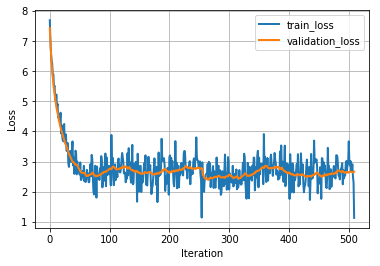

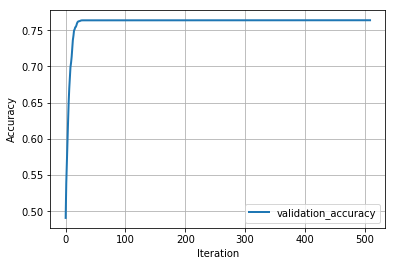

In [39]:
def SGD(X_train, y_train, X_validation, y_validation, W):
    train_loss = np.zeros((epoch * batch_num, ))
    validation_loss = np.zeros((epoch * batch_num, ))
    validation_accuracy = np.zeros((epoch * batch_num, ))
    #train_accuracy = np.zeros((epoch * batch_num, ))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(batch_num):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            train_result = y_train_batch * (X_train_batch.dot(W))
            #print(condition.shape)
            validation_result = y_validation * (X_validation.dot(W))
            train_loss[i * batch_num + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - train_result)) / batch_size
            validation_loss[i * batch_num + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - validation_result)) / validation_num
            validation_accuracy[i * batch_num + j] = np.where(validation_result > 0)[0].size / validation_num
            #train_accuracy[i * batch_num + j] = np.where(train_result > 0)[0].size / batch_size
            W_grad = lbda * batch_size * W - X_train[np.where(train_result <= 1)[0], :].T.dot(y_train[np.where(train_result <= 1)[0], :])
            W_grad = W_grad / batch_size
            W = W - eta * W_grad
    return train_loss, validation_loss, validation_accuracy

train_loss_SGD, validation_loss_SGD, validation_accuracy_SGD = SGD(X_train, y_train, X_validation, y_validation, W_SGD)
show_loss(train_loss_SGD, validation_loss_SGD)
show_accuracy(validation_accuracy_SGD)

## NAG
$$v_t = \gamma v_{t-1} + \eta \cdot \frac{\partial{L}}{\partial{(W - \gamma v_{t-1})}} $$
$$W_{t+1} = W_t - v_t$$

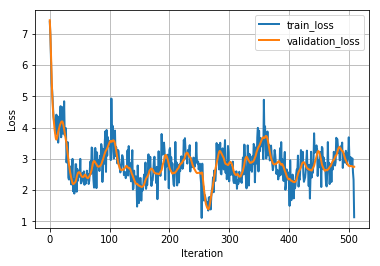

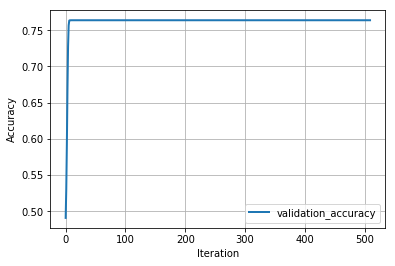

In [40]:
def NAG(X_train, y_train, X_val, y_val, W):
    v = np.zeros((dim, 1))
    train_loss = np.zeros((epoch * batch_num, ))
    val_loss = np.zeros((epoch * batch_num, ))
    validation_accuracy = np.zeros((epoch * batch_num, ))
    #train_accuracy = np.zeros((epoch * batch_num, ))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(batch_num):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            train_result = y_train_batch * (X_train_batch.dot(W))
            validation_result = y_val * (X_val.dot(W))
            train_loss[i * batch_num + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - train_result)) / batch_size
            val_loss[i * batch_num + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda + np.maximum(0, 1 - validation_result)) / validation_num
            validation_accuracy[i * batch_num + j] = np.where(validation_result > 0)[0].size / validation_num
            #train_accuracy[i * batch_num + j] = np.where(train_result > 0)[0].size / batch_size
            W_grad = lbda * batch_size * (W - momentum * v) - X_train[np.where(train_result <= 1)[0], :].T.dot(y_train[np.where(train_result <= 1)[0], :])
            W_grad = W_grad / batch_size
            v = momentum * v + eta * W_grad
            W = W - v
    return train_loss, val_loss, validation_accuracy


train_loss_NAG, val_loss_NAG, val_accuracy_NAG = NAG(X_train, y_train, X_validation, y_validation, W_NAG)
show_loss(train_loss_NAG, val_loss_NAG)
show_accuracy(val_accuracy_NAG)

## RMSProp
$$E[g^2]_t = 0.9E[g^2]_{t - 1} + 0.1g_t^2$$
$$W_{t+1} = W_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_t$$

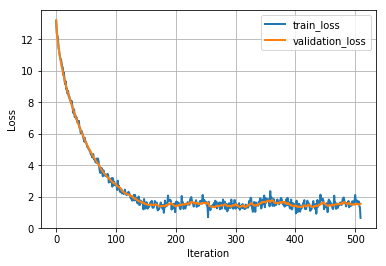

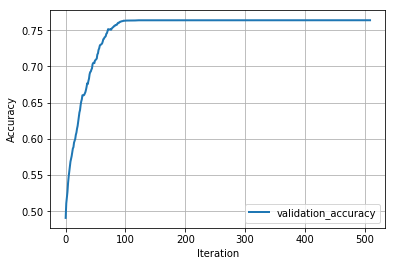

In [42]:
def RMSProp(X_train, y_train, X_val, y_val, W):
    eta_RMSProp = 0.01
    lbda_RMSProp = 0.2
    train_loss = np.zeros((epoch * batch_num, ))
    val_loss = np.zeros((epoch * batch_num, ))
    validation_accuracy = np.zeros((epoch * batch_num, ))
    #train_accuracy = np.zeros((epoch * batch_num, ))
    G_grad = np.zeros((dim, 1))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(batch_num):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            train_result = y_train_batch * (X_train_batch.dot(W))
            validation_result = y_val * (X_val.dot(W))
            train_loss[i * batch_num + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda_RMSProp + np.maximum(0, 1 - train_result)) / batch_size
            val_loss[i * batch_num + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda_RMSProp + np.maximum(0, 1 - validation_result)) / validation_num
            validation_accuracy[i * batch_num + j] = np.where(validation_result > 0)[0].size / validation_num
            #train_accuracy[i * batch_num + j] = np.where(train_result > 0)[0].size / batch_size
            W_grad = lbda_RMSProp * batch_size * W - X_train[np.where(train_result <= 1)[0], :].T.dot(y_train[np.where(train_result <= 1)[0], :])
            W_grad = W_grad / batch_size
            G_grad = momentum * G_grad + (1 - momentum) * np.square(W_grad)
            W = W - eta_RMSProp / np.sqrt(G_grad + np.spacing(1)) * W_grad
    return train_loss, val_loss, validation_accuracy

train_loss_RMSProp, val_loss_RMSProp, val_accuracy_RMSProp = RMSProp(X_train, y_train, X_validation, y_validation, W_RMSProp)
show_loss(train_loss_RMSProp, val_loss_RMSProp)
show_accuracy(val_accuracy_RMSProp)

## AdaDelta
$$E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma) g_t^2$$
$$RMS[g]_t = \sqrt{E[g^2]_t + \epsilon}$$
$$\Delta W_t = - \frac{\eta}{RMS[g]_t} g_t$$
$$E[\Delta W^2]_t = \gamma E[\Delta W^2]_{t-1} + (1 - \gamma) \Delta W_t^2$$
$$RMS[\Delta W]_t = \sqrt{E[\Delta W^2]_t + \epsilon}$$
$$\Delta W_t = - \frac{RMS[\Delta W]_{t-1}}{RMS[g]_t}g_t $$
$$W = W + \Delta W$$

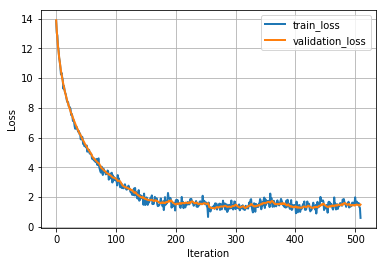

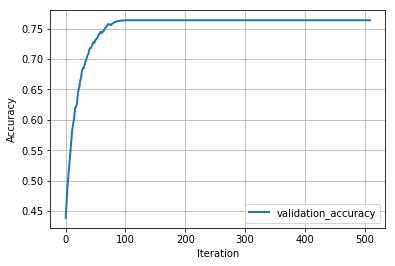

In [8]:
def AdaDelta(X_train, y_train, X_val, y_val, W):
    eta_AdaDelta = 0.01
    lbda_AdaDelta = 0.2
    train_loss = np.zeros((epoch * batch_num, ))
    val_loss = np.zeros((epoch * batch_num, ))
    validation_accuracy = np.zeros((epoch * batch_num, ))
    #train_accuracy = np.zeros((epoch * batch_num, ))
    G_grad = np.zeros((dim, 1))
    E_delta = np.zeros((dim, 1))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(batch_num):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            train_result = y_train_batch * (X_train_batch.dot(W))
            validation_result = y_val * (X_val.dot(W))
            train_loss[i * batch_num + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda_AdaDelta + np.maximum(0, 1 - train_result)) / batch_size
            val_loss[i * batch_num + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda_AdaDelta + np.maximum(0, 1 - validation_result)) / validation_num
            validation_accuracy[i * batch_num + j] = np.where(validation_result > 0)[0].size / validation_num
            #train_accuracy[i * batch_num + j] = np.where(train_result > 0)[0].size / batch_size
            W_grad = lbda_AdaDelta * batch_size * W - X_train[np.where(train_result <= 1)[0], :].T.dot(y_train[np.where(train_result <= 1)[0], :])
            W_grad = W_grad / batch_size
            G_grad = momentum * G_grad + (1 - momentum) * np.square(W_grad)
            RMS_grad = np.sqrt(G_grad + np.spacing(1))
            delta_W = - eta_AdaDelta / RMS_grad * W_grad
            E_delta = momentum * E_delta + (1 - momentum) * np.square(delta_W)
            RMS_delta_W = np.sqrt(E_delta + np.spacing(1))
            W = W - RMS_delta_W / RMS_grad * W_grad
    return train_loss, val_loss, validation_accuracy

train_loss_AdaDelta, val_loss_AdaDelta, val_accuracy_AdaDelta = AdaDelta(X_train, y_train, X_validation, y_validation, W_AdaDelta)
show_loss(train_loss_AdaDelta, val_loss_AdaDelta)
show_accuracy(val_accuracy_AdaDelta)

## Adam
$$m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t$$
$$v_t = \beta_2v_{t-1} + (1-\beta_2)g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$W_{t+1} = W_t - \frac{\eta}{\sqrt{\hat{v}_t + \epsilon}} \hat{m}_t$$

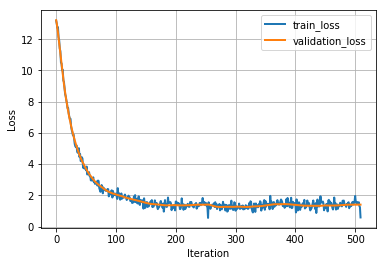

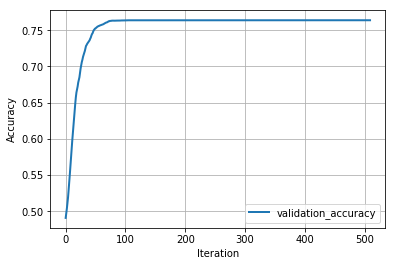

In [44]:
def Adam(X_train, y_train, X_val, y_val, W):
    alpha_Adam = 0.01
    lbda_Adam = 0.2
    train_loss = np.zeros((epoch * batch_num, ))
    val_loss = np.zeros((epoch * batch_num, ))
    validation_accuracy = np.zeros((epoch * batch_num, ))
    #train_accuracy = np.zeros((epoch * batch_num, ))
    beta1 = 0.9
    beta2 = 0.999
    m = np.zeros((dim, 1))
    v = np.zeros((dim, 1))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(batch_num):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            train_result = y_train_batch * (X_train_batch.dot(W))
            validation_result = y_val * (X_val.dot(W))
            train_loss[i * batch_num + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda_Adam + np.maximum(0, 1 - train_result)) / batch_size
            val_loss[i * batch_num + j] = np.sum(np.dot(W.T, W) / 2.0 * lbda_Adam + np.maximum(0, 1 - validation_result)) / validation_num
            validation_accuracy[i * batch_num + j] = np.where(validation_result > 0)[0].size / validation_num
            #train_accuracy[i * batch_num + j] = np.where(train_result > 0)[0].size / batch_size
            W_grad = lbda_Adam * batch_size * W - X_train[np.where(train_result <= 1)[0], :].T.dot(y_train[np.where(train_result <= 1)[0], :])
            m = beta1 * m + (1 - beta1) * W_grad
            v = beta2 * v + (1 - beta2) * np.square(W_grad)
            m_hat = m / (1 - beta1)
            v_hat = v / (1 - beta2)
            W = W - alpha_Adam / (np.sqrt(v_hat) + np.spacing(1)) * m_hat
    return train_loss, val_loss, validation_accuracy

train_loss_Adam, val_loss_Adam, val_accuracy_Adamm = Adam(X_train, y_train, X_validation, y_validation, W_Adam)
show_loss(train_loss_Adam, val_loss_Adam)
show_accuracy(val_accuracy_Adam)

### Compare loss and accuracy

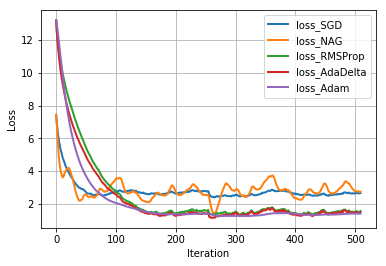

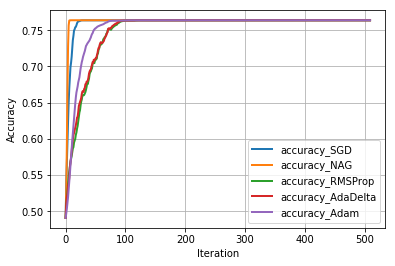

In [45]:
fig, ax = plt.subplots()
ax.plot(validation_loss_SGD, label='loss_SGD', linewidth=2.0)
ax.plot(val_loss_NAG, label='loss_NAG', linewidth=2.0)
ax.plot(val_loss_RMSProp, label='loss_RMSProp', linewidth=2.0)
ax.plot(val_loss_AdaDelta, label='loss_AdaDelta', linewidth=2.0)
ax.plot(val_loss_Adam, label='loss_Adam', linewidth=2.0)
ax.set(xlabel='Iteration', ylabel='Loss')
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()
 
    
fig, ax = plt.subplots()
ax.plot(validation_accuracy_SGD, label='accuracy_SGD', linewidth=2.0)
ax.plot(val_accuracy_NAG, label='accuracy_NAG', linewidth=2.0)
ax.plot(val_accuracy_RMSProp, label='accuracy_RMSProp', linewidth=2.0)
ax.plot(val_accuracy_AdaDelta, label='accuracy_AdaDelta', linewidth=2.0)
ax.plot(val_accuracy_Adam, label='accuracy_Adam', linewidth=2.0)
ax.set(xlabel='Iteration', ylabel='Accuracy')
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()
    